In [1]:
import pandas as pd
import os
import shutil

df = pd.read_csv('tiny-imagenet-200/val/val_annotations.csv')

parent_dir = 'tiny-imagenet-200/val'
for i in range(len(df)):
    image_path = os.path.join(parent_dir, df.loc[i]['Name'])
    if not os.path.exists(image_path):
        os.makedirs(image_path)  # Use makedirs to create parent directories if they don't exist
    shutil.copy(os.path.join(parent_dir, 'images', df.loc[i]['Image']), image_path)

# Remove the images directory
shutil.rmtree(os.path.join(parent_dir, 'images'))

In [7]:
import os
import sys

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Define constants
IMAGE_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 200
EPOCHS = 15 # Increase the number of epochs for better convergence

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'tiny-imagenet-200/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_generator = val_datagen.flow_from_directory(
    'tiny-imagenet-200/val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 100001 images belonging to 200 classes.
Found 9950 images belonging to 200 classes.


Epoch 1/20
1562/1562 [==============================] - 702s 449ms/step - loss: 4.8702 - accuracy: 0.0388 - val_loss: 4.4352 - val_accuracy: 0.0848 - lr: 0.0010
Epoch 2/20
1562/1562 [==============================] - 658s 421ms/step - loss: 4.3351 - accuracy: 0.0975 - val_loss: 4.1236 - val_accuracy: 0.1284 - lr: 0.0010
Epoch 3/20
1562/1562 [==============================] - 683s 437ms/step - loss: 4.1353 - accuracy: 0.1251 - val_loss: 3.9526 - val_accuracy: 0.1541 - lr: 0.0010
Epoch 4/20
1562/1562 [==============================] - 661s 423ms/step - loss: 4.0215 - accuracy: 0.1413 - val_loss: 3.8967 - val_accuracy: 0.1663 - lr: 0.0010
Epoch 5/20
1562/1562 [==============================] - 674s 431ms/step - loss: 3.9447 - accuracy: 0.1516 - val_loss: 3.8228 - val_accuracy: 0.1760 - lr: 0.0010
Epoch 6/20
1562/1562 [==============================] - 719s 460ms/step - loss: 3.8800 - accuracy: 0.1605 - val_loss: 3.7738 - val_accuracy: 0.1788 - lr: 0.0010
Epoch 7/20
1562/1562 [============

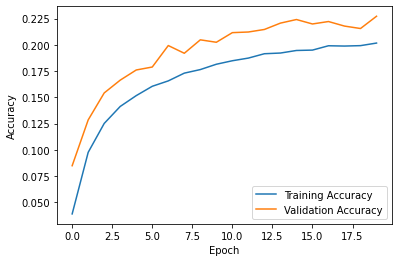

In [2]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()